
# Machine Learning — Notebook 03  
## Métricas “core” para regresión y clasificación (visión general)

### Objetivos
- Practicar métricas fundamentales para:
  - **Regresión**: MAE, RMSE, R² (+ robusta: MedAE).
  - **Clasificación**: Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC.
- Introducir métricas adicionales “robustas” o recomendadas en ciertos contextos:
  - **Balanced Accuracy**
  - **Cohen’s Kappa**
  - **MCC** (Matthews Correlation Coefficient)
- Ver el rol del **umbral (threshold)** en clasificación probabilística.
- Usar **datos simulados** para controlar el problema y comparar:
  - un **baseline** (Dummy),
  - un modelo simple (Decision Tree).

> Nota: el objetivo no es “optimizar”, sino entender **qué mide cada métrica** y **cuándo usarla**.



---
## 0) Setup


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, median_absolute_error,
    mean_absolute_percentage_error, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, balanced_accuracy_score, cohen_kappa_score,
    matthews_corrcoef
)

RANDOM_STATE = 7
rng = np.random.default_rng(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))



---
## 1) Parte A — Regresión: MAE, RMSE, R² (y MedAE)

### Recordatorio rápido
- **MAE**: error absoluto medio, penaliza linealmente.
- **RMSE**: raíz del MSE, penaliza más fuerte errores grandes.
- **R²**: fracción de varianza explicada (relativo a baseline de la media).
- **MedAE**: mediana del error absoluto, robusta a outliers.

En esta sección:
- simulamos datos con relación no perfectamente lineal y ruido,
- incluimos algunos outliers,
- comparamos baseline vs árbol vs regresión lineal.


In [2]:

# 1.1 Simulación de regresión con outliers
n = 900
X = rng.normal(size=(n, 4))

# Señal (semi-lineal) + un toque no lineal
y = 5 + 2.0*X[:,0] - 1.3*X[:,1] + 0.8*(X[:,2]**2) + rng.normal(0, 1.3, size=n)

# Inyectar outliers en y (pocos)
idx_out = rng.choice(n, size=20, replace=False)
y[idx_out] += rng.normal(0, 10.0, size=len(idx_out))  # grandes desviaciones

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

In [3]:
X

array([[ 1.23015336e-03,  2.98745538e-01, -2.74137855e-01,
        -8.90591839e-01],
       [-4.54670785e-01, -9.91646555e-01,  6.01436026e-02,
         1.34021525e+00],
       [-4.92206519e-01, -6.20474900e-01,  4.89842050e-01,
         3.56887008e-01],
       ...,
       [ 1.28937636e+00, -1.60450418e-01,  6.13348801e-01,
         9.99529889e-02],
       [-3.72873062e-01,  3.15028786e+00,  7.11506376e-02,
        -5.37157739e-01],
       [-4.89983330e-01,  3.80574498e-01,  4.09217401e-01,
         7.72011613e-01]])

In [4]:
y

array([ 4.85769960e+00,  3.52158913e+00,  5.70565907e+00,  6.01946915e+00,
        5.42625951e+00,  9.79501279e-01,  9.87819379e+00,  5.68385912e+00,
        4.94745197e+00,  2.16827657e+00,  6.40447458e+00,  1.04814026e+01,
        1.25651389e-01,  3.61579368e+00,  4.54020170e+00,  7.20143371e+00,
        1.45592970e+00,  3.27444439e+00,  3.30551782e+00,  4.31362694e+00,
        5.73895295e+00,  5.23403036e+00,  6.66361202e+00,  1.85431270e+00,
        6.76888335e+00,  6.76963802e+00,  5.64678173e+00,  3.58302479e+00,
        1.60517765e+00,  8.79463738e+00,  5.70552583e+00,  5.55483277e+00,
        1.52985749e+00,  6.87635579e+00,  6.24965421e+00,  7.92885055e+00,
        7.29608729e+00,  6.42848005e+00,  4.64905005e+00,  4.56412932e+00,
        5.27831500e+00,  9.35411634e+00,  6.49846711e+00,  5.76117582e+00,
        9.22232290e+00,  1.57795650e+00,  6.86091161e+00,  7.66946156e+00,
        7.47415416e+00,  5.26182236e+00, -2.26729115e-01,  7.17715824e+00,
        8.80951264e+00,  

In [5]:
X=pd.DataFrame(X,columns=["X{}".format(i) for i in range(4)])
y=pd.DataFrame(y,columns=["Label"])
data1=pd.concat([X,y],axis=1)
data1

,X0,X1,X2,X3,Label
0,0.001230,0.298746,-0.274138,-0.890592,4.857700
1,-0.454671,-0.991647,0.060144,1.340215,3.521589
2,-0.492207,-0.620475,0.489842,0.356887,5.705659
3,0.105414,-0.930468,-0.029252,0.695303,6.019469
4,-1.344215,-0.457616,-1.901223,-1.289538,5.426260
...,...,...,...,...,...
895,-0.941453,1.004658,-2.102044,-0.217864,2.245855
896,2.387212,-0.341535,-1.134785,-0.017955,11.077868
897,1.289376,-0.160450,0.613349,0.099953,10.557448
898,-0.372873,3.150288,0.071151,-0.537158,1.214086


In [6]:
# Modelos
base_reg = DummyRegressor(strategy="mean")
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(max_depth=4, random_state=RANDOM_STATE)

base_reg.fit(X_train, y_train)
lin_reg.fit(X_train, y_train)
tree_reg.fit(X_train, y_train)

# Predicciones
pred_base = base_reg.predict(X_test)
pred_lin  = lin_reg.predict(X_test)
pred_tree = tree_reg.predict(X_test)

def reg_report(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MedAE": median_absolute_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "CORR.COEF": np.corrcoef(y_true, y_pred)[0, 1]
    }

pd.DataFrame([
    reg_report(y_test, pred_base),
    reg_report(y_test, pred_lin),
    reg_report(y_test, pred_tree),
], index=["Dummy(mean)", "LinearRegression", "DecisionTree(max_depth=4)"])


/opt/homebrew/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,MAE,RMSE,R2,MedAE,MAPE,CORR.COEF
Dummy(mean),2.418146,3.238289,-0.000101,2.173984,2.057606,NaN
LinearRegression,1.538139,2.484654,0.411232,1.249844,0.846403,0.650726
DecisionTree(max_depth=4),1.738312,2.604538,0.353045,1.401778,1.052122,0.607757


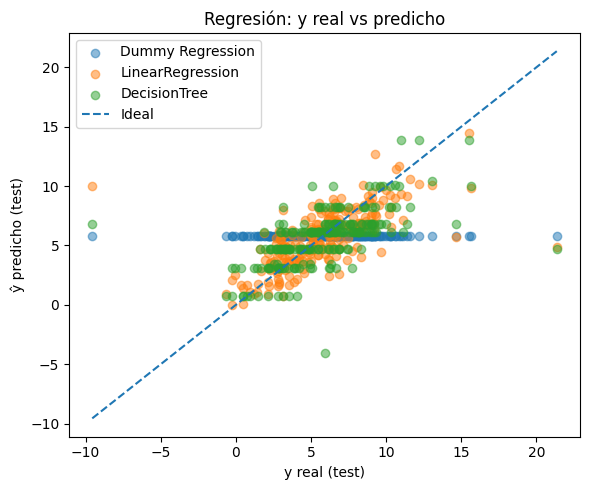

In [7]:

# 1.2 Gráfico diagnóstico: y vs ŷ
plt.figure(figsize=(6,5))
plt.scatter(y_test, pred_base, alpha=0.5, label="Dummy Regression")
plt.scatter(y_test, pred_lin, alpha=0.5, label="LinearRegression")
plt.scatter(y_test, pred_tree, alpha=0.5, label="DecisionTree")
mn = min(y_test.min(), pred_lin.min(), pred_tree.min())
mx = max(y_test.max(), pred_lin.max(), pred_tree.max())
plt.plot([mn, mx], [mn, mx], linestyle="--", label="Ideal")
plt.xlabel("y real (test)")
plt.ylabel("ŷ predicho (test)")
plt.title("Regresión: y real vs predicho")
plt.legend()
plt.tight_layout()
plt.show()



### Comentario interpretativo (rápido)
- Si hay outliers, **RMSE** suele subir más que MAE.
- **MedAE** puede ser más estable si hay pocos outliers muy grandes.
- **R²** es relativo a la variabilidad y puede ser difícil de interpretar si la varianza cambia entre datasets.



---
## 2) Parte B — Clasificación: accuracy, precision, recall, F1, ROC-AUC, PR-AUC

Simulamos un problema binario con **desbalance** y probabilidades.
Compararemos:
- **Dummy** (clase mayoritaria)
- **Árbol de decisión** (simple)
- **Logistic Regression** (modelo probabilístico base)

Incluimos métricas “robustas”:
- **Balanced Accuracy**
- **Cohen’s Kappa**
- **MCC**


In [8]:

# 2.1 Simulación clasificación binaria desbalanceada
n = 2500
Xc = rng.normal(size=(n, 6))

w = np.array([1.2, -1.8, 0.0, 0.6, 0.0, 0.9])
logits = -2.2 + Xc @ w + rng.normal(0, 0.7, size=n)  # intercepto negativo => pocos positivos
p_true = 1 / (1 + np.exp(-logits))
yc = rng.binomial(1, p_true)

X_train, X_test, y_train, y_test = train_test_split(
    Xc, yc, test_size=0.25, random_state=RANDOM_STATE, stratify=yc
)

In [9]:
Xc=pd.DataFrame(Xc,columns=["X{}".format(i) for i in range(6)])
yc=pd.DataFrame(yc,columns=["Label"])
data2=pd.concat([Xc,yc],axis=1)
data2

,X0,X1,X2,X3,X4,X5,Label
0,0.950753,0.208829,-0.874545,0.294192,-2.073985,-0.340005,0
1,0.469926,0.643107,-0.829397,0.858218,1.815146,-0.481219,0
2,0.686710,-1.611715,-2.016133,0.558797,-0.010533,0.146454,1
3,-0.636287,-0.346797,0.758107,1.665701,-0.269089,-1.703231,0
4,1.222486,0.550751,0.630251,0.130431,2.272222,0.024090,0
...,...,...,...,...,...,...,...
2495,1.959433,0.703833,-0.600080,0.800073,0.078149,1.544815,0
2496,-1.585979,0.115599,0.991833,-1.243741,-0.724387,0.489438,0
2497,0.054105,-0.283296,0.322009,-1.361827,-0.815418,1.735419,0
2498,-0.622929,0.451033,-0.034639,0.870545,0.344361,0.418850,0


In [10]:
# Modelos
dummy_clf = DummyClassifier(strategy="most_frequent")
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE)
log_clf = LogisticRegression(max_iter=5000)

dummy_clf.fit(X_train, y_train)
tree_clf.fit(X_train, y_train)
log_clf.fit(X_train, y_train)

# Probabilidades
p_dummy = dummy_clf.predict_proba(X_test)[:, 1]
p_tree  = tree_clf.predict_proba(X_test)[:, 1]
p_log   = log_clf.predict_proba(X_test)[:, 1]

# Tasa de positivos en test
y_test.mean()


np.float64(0.2304)

### Métricas (definiciones cortas)

- **Accuracy**: proporción total de aciertos \((TP+TN)/N\).
- **BalancedAcc**: promedio del recall por clase (útil en desbalance).
- **Precision**: de los predichos como positivos, ¿cuántos son correctos? \(TP/(TP+FP)\).
- **Recall**: de los positivos reales, ¿cuántos detecto? \(TP/(TP+FN)\).
- **F1**: balance entre precision y recall \(2PR/(P+R)\).
- **ROC_AUC**: área bajo la curva ROC (separación global entre clases a todos los umbrales).
- **PR_AUC**: área bajo la curva Precision–Recall (muy informativa con pocos positivos).
- **Kappa**: acuerdo entre predicción y verdad *corrigiendo por azar*.
- **MCC**: correlación entre predicción y verdad (robusta en desbalance).
- **TP**: verdadero positivo (1 real, 1 predicho).
- **FP**: falso positivo (0 real, 1 predicho).
- **FN**: falso negativo (1 real, 0 predicho).
- **TN**: verdadero negativo (0 real, 0 predicho).

### Rangos típicos y “qué es mejor” (guía rápida)

- **Accuracy**: \([0,1]\) → **más alto es mejor** (1 perfecto). *Ojo:* engañosa con desbalance.
- **BalancedAcc**: \([0,1]\) → **más alto es mejor** (0.5 ≈ azar en binaria balanceada).
- **Precision**: \([0,1]\) → **más alto es mejor** (1 = sin falsos positivos).
- **Recall**: \([0,1]\) → **más alto es mejor** (1 = sin falsos negativos).
- **F1**: \([0,1]\) → **más alto es mejor** (1 perfecto).
- **ROC_AUC**: \([0,1]\) → **más alto es mejor** (0.5 ≈ azar, 1 perfecto; <0.5 peor que azar).
- **PR_AUC (Average Precision)**: \([0,1]\) → **más alto es mejor**. La referencia mínima es aprox. la **tasa de positivos** (\(\pi\)).
- **Kappa**: \([-1,1]\) → **más alto es mejor** (0 ≈ azar, 1 perfecto, <0 peor que azar).
- **MCC**: \([-1,1]\) → **más alto es mejor** (0 ≈ azar, 1 perfecto, <0 peor que azar).
- **TP, FP, FN, TN**: conteos $\ge 0$ → “mejor” depende del objetivo:
  - **TP y TN**: queremos **altos** (aciertos).
  - **FP y FN**: queremos **bajos** (errores).  
    - Si es crítico no perder positivos → minimizar **FN** (sube recall).
    - Si es crítico evitar falsas alarmas → minimizar **FP** (sube precision).


In [11]:

# 2.2 Reporte de métricas (umbral 0.5)
def clf_report(y_true, proba, thr=0.5):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    return {
        "Accuracy": accuracy_score(y_true, pred),
        "BalancedAcc": balanced_accuracy_score(y_true, pred),
        "Precision": precision_score(y_true, pred, zero_division=0),
        "Recall": recall_score(y_true, pred, zero_division=0),
        "F1": f1_score(y_true, pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, proba),
        "PR_AUC": average_precision_score(y_true, proba),
        "Kappa": cohen_kappa_score(y_true, pred),
        "MCC": matthews_corrcoef(y_true, pred),
        "TP": cm[1,1], "FP": cm[0,1], "FN": cm[1,0], "TN": cm[0,0],
    }

pd.DataFrame([
    clf_report(y_test, p_dummy),
    clf_report(y_test, p_tree),
    clf_report(y_test, p_log),
], index=["Dummy(most_frequent)", "DecisionTree(max_depth=4)", "LogisticRegression"])


,Accuracy,BalancedAcc,Precision,Recall,F1,ROC_AUC,PR_AUC,Kappa,MCC,TP,FP,FN,TN
Dummy(most_frequent),0.7696,0.500000,0.000000,0.000000,0.000000,0.500000,0.230400,0.000000,0.000000,0,0,144,481
DecisionTree(max_depth=4),0.8256,0.733433,0.637795,0.562500,0.597786,0.825616,0.610088,0.487007,0.488573,81,46,63,435
LogisticRegression,0.8368,0.713950,0.714286,0.486111,0.578512,0.881815,0.729618,0.481817,0.495538,70,28,74,453


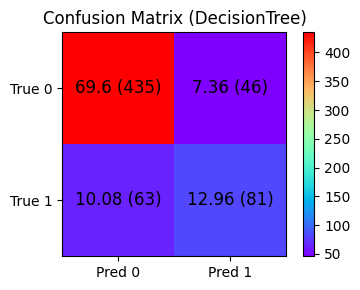

In [12]:

# 2.3 Confusion matrix: árbol (thr=0.5)
thr = 0.5
pred_tree = (p_tree >= thr).astype(int)
cm = confusion_matrix(y_test, pred_tree)

plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation="nearest", cmap="rainbow")
plt.title("Confusion Matrix (DecisionTree)")
plt.colorbar()
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(np.round(cm[i, j]/cm.sum()*100,2))+" ("+str(cm[i, j])+")", ha="center", va="center", fontsize=12)
plt.tight_layout()
plt.show()



---
## 3) ROC curve y PR curve (comparación de modelos)


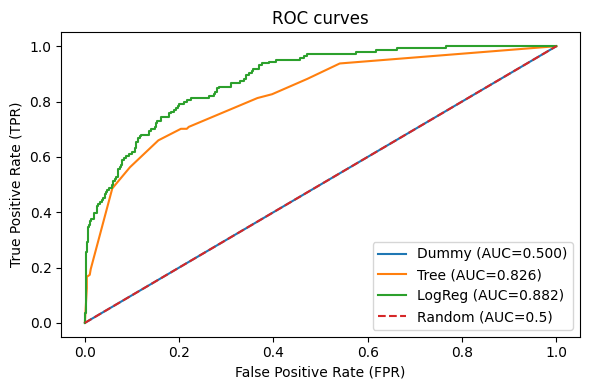

In [13]:

# 3.1 ROC curve
plt.figure(figsize=(6,4))
for name, proba in [("Dummy", p_dummy), ("Tree", p_tree), ("LogReg", p_log)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1], linestyle="--", label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC curves")
plt.legend()
plt.tight_layout()
plt.show()


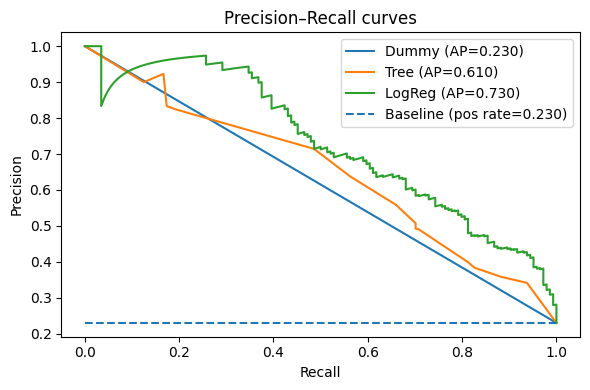

In [14]:

# 3.2 PR curve
plt.figure(figsize=(6,4))
for name, proba in [("Dummy", p_dummy), ("Tree", p_tree), ("LogReg", p_log)]:
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline (pos rate={baseline:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves")
plt.legend()
plt.tight_layout()
plt.show()


## TP, TN, FP, FN (matriz de confusión)

En un problema de **clasificación binaria** (clase positiva = 1, negativa = 0), al comparar la **verdad** vs la **predicción** aparecen cuatro casos:

- **TP (True Positive / Verdadero Positivo)**: el caso era **positivo (1)** y el modelo lo predijo **positivo**.  
  *Ej.: era fraude y lo detecté como fraude.*

- **TN (True Negative / Verdadero Negativo)**: el caso era **negativo (0)** y el modelo lo predijo **negativo**.  
  *Ej.: no era fraude y lo dejé pasar.*

- **FP (False Positive / Falso Positivo)**: el caso era **negativo (0)** pero el modelo lo predijo **positivo**.  
  *Ej.: no era fraude pero lo marqué como fraude (alarma falsa).*

- **FN (False Negative / Falso Negativo)**: el caso era **positivo (1)** pero el modelo lo predijo **negativo**.  
  *Ej.: era fraude pero no lo detecté.*

Estos cuatro valores forman la **matriz de confusión** y permiten calcular métricas como accuracy, precision, recall y F1.


## Mini-manual: cómo leer una ROC curve y una Precision–Recall curve

### 1) ROC curve (TPR vs FPR)
La **ROC** muestra el desempeño del clasificador para *todos* los umbrales:
- **Eje Y (TPR / Recall)**: $ \text{TPR}=\frac{TP}{TP+FN} $  → “¿cuántos positivos reales detecto?”
- **Eje X (FPR)**: $ \text{FPR}=\frac{FP}{FP+TN} $ → “¿cuántos negativos convierto en falsos positivos?”

**Cómo interpretarla**
- La línea diagonal es un clasificador **aleatorio** (AUC ≈ 0.5).
- Cuanto más cerca esté la curva de la esquina **arriba-izquierda**, mejor: alta TPR con baja FPR.
- **ROC-AUC** es el área bajo la curva:  
  - 0.5 ≈ azar  
  - 1.0 ≈ separación perfecta  
- Útil para medir **capacidad de separación** en general, pero puede ser optimista cuando hay **desbalance fuerte**.

---

### 2) Precision–Recall curve (Precision vs Recall)
La **PR** es especialmente útil cuando hay pocos positivos.
- **Recall**: $ \frac{TP}{TP+FN} $
- **Precision**: $ \frac{TP}{TP+FP} $ → “de los que dije positivos, ¿cuántos eran positivos?”

**Cómo interpretarla**
- La línea base horizontal suele ser la **tasa de positivos** (\(\pi=\frac{\#\text{pos}}{N}\)).  
  Si tu curva está cerca de esa línea, el modelo aporta poco.
- Cuanto más arriba y a la derecha (alta precision y alto recall), mejor.
- **PR-AUC (Average Precision)** resume la curva; suele ser más informativa que ROC-AUC cuando la clase positiva es rara.

---

### 3) Umbrales: el “punto” que eliges en la curva
Cada punto de la ROC o PR corresponde a un umbral \(\tau\):
$$
\hat{y}=\mathbf{1}[p(y=1\mid x)\ge \tau]
$$
- Bajar $\tau$ → sube **recall**, baja **precision** (más positivos detectados, pero más falsas alarmas).
- Subir $\tau$ → sube **precision**, baja **recall** (menos falsas alarmas, pero más positivos perdidos).

**Regla práctica**
- Si es muy costoso perder positivos (**FN alto**) → prioriza **recall** / **PR-AUC**.
- Si es muy costoso generar alarmas falsas (**FP alto**) → prioriza **precision**.



---
## 4) Threshold (umbral): cómo cambia Precision/Recall/F1

En clasificación probabilística, un umbral \(\tau\) transforma probabilidades en clase:

$$
\hat{y}=\mathbb{1}[p(y=1\mid x)\ge \tau]
$$

- Bajar $\tau$ ↑ recall y ↓ precision (usualmente).
- Subir $\tau$ ↑ precision y ↓ recall (usualmente).


In [15]:

thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    rep = clf_report(y_test, p_tree, thr=float(t))
    rep["thr"] = float(t)
    rows.append(rep)

thr_df = pd.DataFrame(rows).set_index("thr")[["Precision","Recall","F1","BalancedAcc","Kappa","MCC"]]
thr_df


,Precision,Recall,F1,BalancedAcc,Kappa,MCC
thr,,,,,,
0.05,0.341772,0.937500,0.500928,0.698480,0.246465,0.346607
0.10,0.399317,0.812500,0.535469,0.723298,0.327783,0.376847
0.15,0.399317,0.812500,0.535469,0.723298,0.327783,0.376847
0.20,0.492683,0.701389,0.578797,0.742586,0.422479,0.435160
0.25,0.492683,0.701389,0.578797,0.742586,0.422479,0.435160
0.30,0.558824,0.659722,0.605096,0.751899,0.473827,0.476737
0.35,0.558824,0.659722,0.605096,0.751899,0.473827,0.476737
0.40,0.637795,0.562500,0.597786,0.733433,0.487007,0.488573
0.45,0.637795,0.562500,0.597786,0.733433,0.487007,0.488573


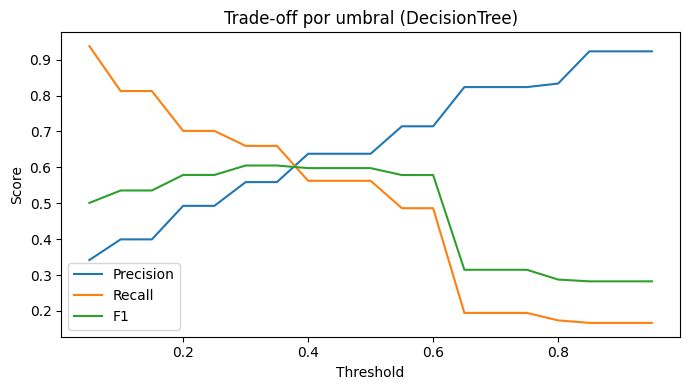

In [16]:

plt.figure(figsize=(7,4))
plt.plot(thr_df.index, thr_df["Precision"], label="Precision")
plt.plot(thr_df.index, thr_df["Recall"], label="Recall")
plt.plot(thr_df.index, thr_df["F1"], label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Trade-off por umbral (DecisionTree)")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretación de la gráfica “Trade-off por umbral (DecisionTree)”

Esta gráfica muestra cómo cambian **Precision**, **Recall** y **F1** cuando variamos el **umbral** (threshold) que convierte probabilidades en clases.

#### 1) ¿Qué es el umbral $\tau$?
Un clasificador probabilístico entrega una probabilidad $\hat{p}(x)=P(y=1\mid x)$.  
Para decidir la clase final usamos un umbral $\tau$:

$$
\hat{y}(x)=\mathbf{1}\big[\hat{p}(x)\ge \tau\big]
$$

- Si $\hat{p}(x)\ge \tau$ → predecimos **1** (positivo).
- Si $\hat{p}(x)< \tau$ → predecimos **0** (negativo).

#### 2) ¿Qué pasa cuando sube o baja $\tau$?
- **$\tau$ bajo** (ej. 0.10–0.20): el modelo “se anima” a predecir positivos con facilidad.  
  → **Recall alto** (detecta muchos positivos), pero **Precision más baja** (más falsos positivos).

- **$\tau$ alto** (ej. 0.80–0.90): el modelo exige mucha evidencia para decir “positivo”.  
  → **Precision alta** (pocos falsos positivos), pero **Recall bajo** (se le escapan muchos positivos).

Esto se ve claramente en la figura:
- La **línea naranja (Recall)** empieza alta con umbrales bajos y cae al aumentar $\tau$.
- La **línea azul (Precision)** sube a medida que aumenta $\tau$.
- La **línea verde (F1)** (balance entre precision y recall) suele tener un **máximo intermedio**.

#### 3) ¿Por qué F1 tiene un máximo en el medio?
Porque:

$$
F1 = 2\cdot\frac{\text{Precision}\cdot \text{Recall}}{\text{Precision}+\text{Recall}}
$$

- Si $\tau$ es muy bajo: Recall alto pero Precision baja → F1 no crece tanto.
- Si $\tau$ es muy alto: Precision alta pero Recall muy baja → F1 cae.
- En un umbral intermedio, se logra un **mejor compromiso** y F1 se maximiza.

#### 4) ¿Cómo escoger $\tau$ en la práctica?
Depende del costo del error:
- Si es peor **perder positivos** (**FN** caro): elige $\tau$ más bajo → prioriza **Recall**.
- Si es peor **falsas alarmas** (**FP** caro): elige $\tau$ más alto → prioriza **Precision**.
- Si quieres equilibrio general: elige $\tau$ que maximice **F1** (o una métrica objetivo definida por el negocio).



---
## 5) Ejercicios (Semana 3)

### Ejercicio 1 — Regresión: escoger métrica y justificar
En cada caso, elige una métrica principal (MAE/RMSE/R²/MedAE) y justifica:
1) Predicción de demanda: outliers grandes ocurren en eventos (festivos, conciertos).  
2) Predicción de temperatura: errores grandes son raros, pero importa ser preciso.  
3) Predicción de un indicador socioeconómico con datos ruidosos y atípicos.

### Ejercicio 2 — Clasificación: escoger métrica y justificar
Elige métricas para:
1) Detección de fraude (pocos positivos, costo alto de FN).  
2) Filtro de spam (costo alto de FP para algunos usuarios).  
3) Diagnóstico médico (FN muy costoso).

### Ejercicio 3 — Threshold
1) Para el árbol, encuentra un umbral que maximice **F1**.  
2) Encuentra un umbral que logre Recall ≥ 0.80 (si es posible).  
3) Explica cuál escogerías en un problema donde FN cuestan 10× más que FP.

### Ejercicio 4 — Métricas robustas
1) ¿Por qué **Kappa** y **MCC** pueden ser más informativas que accuracy en desbalance?  
2) Da un ejemplo donde dos modelos tengan accuracy similar pero MCC diferente.
